In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.cluster import KMeans
from lp_solve import *

In [2]:
def write_lpfile(f,A,B,option="min",name="to_solve"):
    '''
    Write the .lp file to put in the lp_solve.
    Solves:
    min/max <x,f>
    w.t. Ax <= B
    '''
    
    n = f.shape[0]-1
    file = open(name+".lp","w")
    #Write the objective function
    file.write("/* Objective function */\n")
    file.write(option+": ")
    towrite = []
    for idx,k in enumerate(f):
        if k != 0:
            towrite.append(str(k)+"x"+str(idx))
        
    towrite = " + ".join(towrite) + ";\n"
    file.write(towrite)
    file.write("\n")
    
    #Write the variable bounds
    file.write("/* Variable bounds */\n")
    for a,b in zip(A,B):
        towrite = []
        for idx,k in enumerate(a):
            if k != 0:
                towrite.append(str(k)+"x"+str(idx))
        towrite = " + ".join(towrite) + " <= " + str(b) + ";\n"
        file.write(towrite)
    file.close()

In [326]:
def generate_data(mean,std,size):
    dim = mean.shape[0]
    if np.array(std).shape == ():
        cov = np.eye(dim)*std
    else:
        cov = std
    X = np.random.multivariate_normal(mean=mean,cov=cov,size=(size))
    W = np.sum((X-mean)**2,1)
    return X,W

def EMD_prob(X1,W1,X2,W2,dist="euclid"):
    '''
    This function returns the EMD optimization problem in the following form:
    min d'x
    w.t. Ax <= b
    
    Args: 
    The two datasets we want to comput the EMD of, 
    X1: n x d array, points of the first dataset
    W1: n vector, weights of the first dataset
    X2: m x d array, points of the second dataset
    W2: m vector, weight of the second dataset
    
    Output:
    d: n*m vector, objective function
    A: n*m+n+m+2 x n*m array, inequality matrix of constraints
    b: n*m+n+m+2 vector, inequality vector of constraints
    '''
    
    n = X1.shape[0]
    m = X2.shape[0]
    D = np.zeros((n,m))
    
    if dist == "euclid":
        x1s = np.diag(X1@X1.T).reshape(n,1)
        x2s = np.diag(X2@X2.T).reshape(1,m)
        D = -2*X1@X2.T + x1s + x2s
    else:
        for i,x1 in enumerate(X1):
            for j,x2 in enumerate(X2):
                D[i,j] = dist(x1,x2)
    d = D.ravel()
    
    A1 = -np.eye(n*m)                      #constraints on direction of flow
    A2 = np.kron(np.eye(n),np.ones(m))     #constraints on weights of X1
    A3 = np.kron(np.ones(n),np.eye(m))     #constraints on weights of X2
    A4 = np.vstack([np.ones(n*m),-np.ones(n*m)])  #constraints on total flow
    
    b1 = np.zeros(n*m)
    b2 = W1
    b3 = W2
    b4 = min(W1.sum(),W2.sum()) + np.zeros(2)
    
    A = np.vstack((A1,A2,A3,A4))
    b = np.hstack((b1,b2,b3,b4))
    
    return d,A,b

def EMD(X1,W1,X2,W2,dist="euclid"):
    '''
    This function solves the EMD optimization problem.
    
    Args: 
    The two datasets we want to comput the EMD of, 
    X1: n x d array, points of the first dataset
    W1: n vector, weights of the first dataset
    X2: m x d array, points of the second dataset
    W2: m vector, weight of the second dataset
    
    Output:
    EMD: positive number, value of the EMD
    x: n*m vector, solution of the problem
    time: positive number, time taken to solve the problem
    '''
    n=X1.shape[0]
    m=X2.shape[0]
    d,A,b = EMD_prob(X1,W1,X2,W2,dist)
    [obj,x,duals,time] = lp_solve(d,A,b)
    emd = obj/min(W1.sum(),W2.sum())
    x = np.array(x).reshape(n,m)
    return [emd,x,time]

In [137]:
sigms = 1
sigma1 = sigms
sigma2 = sigms
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])


n = 100
m = 100

X1,W1 = generate_data(mean1,sigma1,n)
Y1 = 0+np.zeros(n)
X2,W2 = generate_data(mean2,sigma2,m)
Y2 = 1+np.zeros(m)


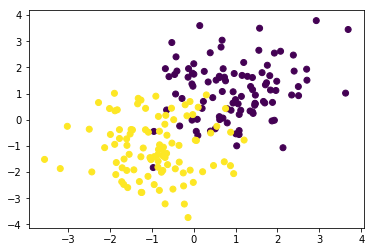

In [138]:
X = np.c_[X1.T,X2.T].T
Y = np.c_[Y1.T,Y2.T].T.reshape(n+m)
plt.scatter(X[:,0],X[:,1],c=Y)

In [114]:
def dist(x,y):
    return np.sum(np.abs(x-y))

def euclid(x,y):
    return np.sum((x-y)**2)

d,A,b = EMD_prob(X1,W1,X2,W2)
d1,A1,b1 = EMD_prob(X1,W1,X2,W2,euclid)
emd,x,time = EMD(X1,W1,X2,W2)
time


0.05499982833862305

In [91]:
sigms = 1
sigma1 = sigms
sigma2 = sigms
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])

ns = np.array([50,60,70,90,110])
ms = np.array([50,60,70,90,110])
num_of_rep = 5

objs = np.zeros((ns.shape[0],ms.shape[0]))
times = np.zeros((ns.shape[0],ms.shape[0]))

for i in tqdm(range(ns.shape[0])):
    n=ns[i]
    for j,m in enumerate(ms):
        if m < n:
            continue
        X1,W1 = generate_data(mean1,sigma1,n)
        X2,W2 = generate_data(mean2,sigma2,m)
        
        current_obj = np.zeros(num_of_rep)
        current_time = np.zeros(num_of_rep)
        for k in range(num_of_rep):
            current_obj[k],_,current_time[k] = EMD(X1,W1,X2,W2)
        objs[i,j],times[i,j] = current_obj.mean(),current_time.mean()
        
timespd = pd.DataFrame(times,index=ns,columns=ms)
timespd.to_pickle("time_q4.pkl")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [55]:
times = pd.read_pickle("time_q4.pkl")

ns = times.index
ms = times.columns

absis = []
ords = []
for i,n in enumerate(ns):
    for j,m in enumerate(ms):
        if m < n:
            continue
        absis.append(n*m)
        ords.append(times.iloc[i,j])
absis = np.array(absis)
ords = np.array(ords)

In [56]:
ords = ords[absis.argsort()]
absis = absis[absis.argsort()]

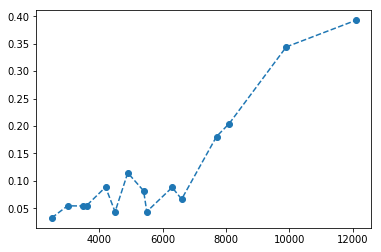

In [68]:
plt.plot(absis,ords,"--o")

In [345]:
def compare_clusters(C1,C2,weights=None):
    '''
    This algorithm compares two clusters.
    Notations:
    k: number of clusters
    n: number of points
    
    Args:
    C1: k x n array, matrix of soft clustering
    C2: k x n array, matrix of soft clustering
    weights:  None OR tuple of two k vectors.
    If weights = None, the weights will be the sum of the coefficients for each cluster.
    
    Output:
    Earth Moving Distance
    '''
    
    def l1_dist(x1,x2):
        return np.sum(np.abs(x1-x2))
    
    if weights is None:
        W1,W2 = C1.sum(1)/C1.sum(),C2.sum(1)/C2.sum()
    else:
        W1,W2 = weights
    
    #assert W1.sum() == 1 and W2.sum() == 1, "Weights must sum to 1"
    print(C1.shape,W1.shape,C2.shape,W2.shape)
    emd,x,time = EMD(C1,W1,C2,W2,l1_dist)
    return emd

In [279]:
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])
mean3 = np.array([1,-1])
mean4 = np.array([-1,1])

std = 0.4
std1 = np.array([[0.2*std,0],
                 [0,std]])
std2 = 0.5*np.array([[std,0.3*std],
                 [0.3*std,std]])
std3 = 0.7*std
std4 = np.array([[std,0],
                 [0,0.1*std]])

size = 200

X1,_ = generate_data(mean=mean1,std=std1,size=size)
X2,_ = generate_data(mean=mean2,std=std2,size=size)
X3,_ = generate_data(mean=mean3,std=std3,size=size)
X4,_ = generate_data(mean=mean4,std=std4,size=size)

Y1 = np.zeros(size)+1
Y2 = np.zeros(size)+2
Y3 = np.zeros(size)+3
Y4 = np.zeros(size)+4

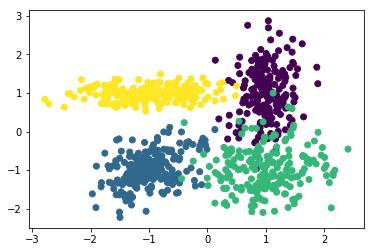

In [280]:
X = np.c_[X1.T,X2.T,X3.T,X4.T].T
Y = np.c_[Y1.T,Y2.T,Y3.T,Y4.T].T.reshape(4*size)
plt.scatter(X[:,0],X[:,1],c=Y)

array([105, 128, 175, 190, 202], dtype=int64)

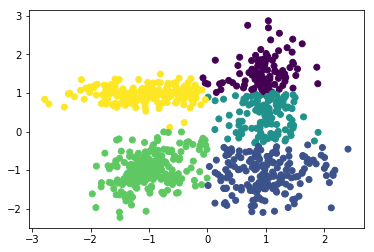

In [295]:
kmeans = KMeans(n_clusters=5,init="random")
clusters = kmeans.fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=clusters)
p = np.unique(clusters,return_counts=1)[1]
p.sort()
p

In [350]:
n = X.shape[0]

k1 = 5
c1 = np.zeros((n,k1))
kmeans1 = KMeans(n_clusters=k1,init="random")
clusters1 = kmeans1.fit_predict(X)
c1[np.arange(n),clusters1]=1
c1=c1.T

k2 = 4
c2 = np.zeros((n,k2))
kmeans2 = KMeans(n_clusters=k2,init="random")
clusters2 = kmeans2.fit_predict(X)
c2[np.arange(n),clusters2]=1
c2=c2.T


In [344]:
c1

array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [358]:
compare_clusters(c1,c1)

(5, 800) (5,) (5, 800) (5,)


337.345

In [334]:
(c1-c2).sum()

0.0